# 変分オートエンコーダを用いた分子生成
生成を制御する機構を持つ分子生成モデルとして変分オートエンコーダにもとづく分子生成モデルを説明する。

# 5.1 変分ベイズ法
**変分オートエンコーダ**（VAE）とは、変分ベイズ法を用いて定義されるオートエンコーダ型のニューラルネットワークである。**オートエンコーダ**（auto-encoder, 自己符号化器）とは、データを実数値ベクトルに変換するエンコーダと実数値ベクトルからデータを復元するデコーダの対のことである。

## 5.1.1 ベイズ推論（Bayesian inference）
ベイズ推測はデータに相当する確率変数Xとデータにもとづいて推測したい確率変数Zをもとに定義される手続きことである。データに相当する確率変数Xはデータ単体とは限らず、複数のデータから成るサンプルなどの場合もある。一般的なベイズ推論ではデータによって推測したい未知量のすべてとなる。例えば、パラメトリックモデルのパラメータもZに含めることがある。

ここでデータを観測していな状態でのZに対する事前知識$pz(x)$を**事前分布**という。また$Z=z$が与えられたもとで、観測されるデータ$X$が従う確率分布を$p_{X|Z}(x|z)$として、$p_z$と$p_{X|Z}$が既知であるとする。このとき、データ$X$に関する周辺分布
$$
p_X(x) = \int p_{X|Z}(x|z) p_Z(z) dz
$$

を用いて、実現値$X=x$が与えられた下での$Z$の事後分布が
$$
p_{Z|X}(z|x) = \frac{p_{X|Z}(x|z) p_Z(z)}{p_X(x)}
$$
と導出できる。これを**ベイズの法則**あるいは**ベイズの定理**という。つまり、推測したい未知量$Z$に関する知識が、事前の知識$p_Z$から事後的な知識$p_{Z|X}$に更新されたことを表現している。このように、ベイズ推測は、推測したい確率変数を$Z$として確率モデルを作り、$Z$に関する事後分布を計算することで$Z$の取りそうな値を確率分布の形で知るための手法である。

しかしながら、周辺分布$p_X(x)$の計算には一般的に膨大な時間を要することが多く、事後分布を計算することが困難であることが多いため、厳密な計算はあきらめ、マルコフ連鎖モンテカルロ法や変分ベイズ法を用いる。とくに、変分ベイズ法はニューラルネットワークとの相性が良いため、ニューラルネットワークと組み合わせて使われることが多い。

## 5.1.2 変分ベイズ法（variational Baysian method）
**変分ベイズ法**は事後分布$p_{Z|X}$が計算困難な状況下でパラメータ$\phi$で特徴づけられるパラメトリックな確率モデル$q_{\phi}$を導入し、それを事後分布$p_{Z|X}$になるべく近づけるような$\phi^*$を求め、得られた$q_{\phi^*}$を事後分布の近似とする手法である。この$q_{\phi}$のことを変分分布（variational distribution）と呼ぶ。事後分布を近似するような変分分布$q_{\phi}$を求めるためには事後分布と変分分布の間の近さを測る尺度を用いて最適化問題として定式化したうえでその最小化問題を解く手法が必要になる。

### 事後分布近似の最適化問題としての定式化
事後分布と変分分布の近さを測る手法として**KL情報量**を用いる。
$$
\phi^* = \argmax_{\phi} \mathrm{KL}(q_{\phi}(z) \| p_{Z|X}(z | x))
$$
これより、$\phi^*$を求め、$q_{\phi^*}(z)$を事後分布$p_{Z|X}(z | x)$の近似とするのが変分ベイズ法である。ただし、このままでは計算式中の$p_{Z|X}$が計算困難であるから計算できない。そこで、計算可能な目的関数を持つ最適化問題を導出する。
$$
\begin{align}
&\mathrm{KL} (q_{\phi}(z) \| p_{Z|X}(z | x)) \\
&= \int q_{\phi}(z) \log \left( \frac{q_{\phi}(z)}{p_{Z|X}(z | x)} \right) dz \\
&= \int q_{\phi}(z) \log \left( \frac{q_{\phi}(z) p_X(x)}{p_{X, Z}(x, z)} \right) dz \\
&= \int q_{\phi}(z) \left[ -\log \left( \frac{p_{X, Z}(x, z)}{q_{\phi}(z)} \right) + \log p_X(x) \right] dz \\
&= -\mathbb{E}_{Z \sim q_{\phi}} [\log p_{X, Z}(x, Z)] + \mathbb{E}_{Z \sim q_{\phi}}[\log q_{\phi}(Z)] + \log p_X(x)
\end{align}
$$

となる。上式において$\log p_X(x)$は$q_{\phi}$に依存しないため、最適解を求めるうえでは無視できる。よって、
$$
\phi^* = \argmax_{\phi} - \mathbb{E}_{Z \sim q_{\phi}} [\log p_{X, Z}(x, Z)] + \mathbb{E}_{Z \sim q_{phi}} [\log q_{\phi} (Z)]
$$
という最適化問題を解けばよい。ここで、$X$と$Z$の同時分布$p_{X, Z}$は一般に容易に計算できる。期待値に関してもモンテカルロ近似することで近似値を計算することができる。

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import OneHotCategorical, Categorical
from tqdm import tqdm
from smiles_vocab import SmilesVocabulary

class SmilesVAE(nn.Module):
    def __init__(
        self, vocab, latent_dim, emb_dim=128, max_len=100,
        encoder_params={"hidden_size": 128, "num_layers": 1, "dropout": 0.},
        decoder_params={"hidden_size": 128, "num_layers": 1, "dropout": 0.},
        encoder2out_params={"out_dim_list": [128, 128]}
    ):
        """_summary_

        Parameters
        ----------
        vocab : SmilesVocabulary
            SmilesVocabularyクラスのインスタンス
        latent_dim : int
            _description_
        emb_dim : int, optional
            _description_, by default 128
        max_len : int, optional
            _description_, by default 100
        encoder_params : dict, optional
            _description_, by default {"hidden_size": 128, "num_layers": 1, "dropout": 0.}
        decoder_params : dict, optional
            _description_, by default {"hidden_size": 128, "num_layers": 1, "dropout": 0.}
        encoder2out_params : dict, optional
            _description_, by default {"out_dim_list": [128, 128]}
        """
        super().__init__()
        self.vocab = vocab
        vocab_size = len(self.vocab.char_list)
        self.max_len = max_len
        self.latent_dim = latent_dim
        self.beta = 1.0

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=vocab.pad_idx
        )
        self.encoder = nn.LSTM(
            emb_dim, batch_first=True, **encoder_params
        )
        self.encoder2out = nn.Sequential()
        in_dim = encoder_params["hidden_size"] * 2 if encoder_params.get("bidirectional", False) else encoder_params["hidden_size"]
        for each_out_dim in encoder2out_params["out_dim_list"]:
            self.encoder2out.append(
                nn.Linear(in_dim, each_out_dim)
            )
            self.encoder2out.append(nn.Sigmoid())
            in_dim = each_out_dim

        self.encoder_out2mu = nn.Linear(in_dim, latent_dim)
        self.encoder_out2logvar = nn.Linear(in_dim, latent_dim)

        self.latent2dech = nn.Linear(
            in_features=latent_dim,
            out_features=decoder_params["hidden_size"] * decoder_params["num_layers"]
        )
        self.latent2decc = nn.Linear(
            in_features=latent_dim,
            out_features=decoder_params["hidden_size"] * decoder_params["num_layers"]
        )
        self.latent2emb = nn.Linear(in_features=latent_dim, out_features=emb_dim)
        self.decoder = nn.LSTM(
            emb_dim, batch_first=True, bidirectional=False, **decoder_params
        )
        # アルファベット集合上の確率ベクトルのロジット値に変換する
        self.decoder2vocab = nn.Linear(
            in_features=decoder_params["hidden_size"], out_features=vocab_size
        )
        self.out_dist_cls = Categorical
        self.loss_func = nn.CrossEntropyLoss(reduction="none")

    @property
    def device(self):
        return next(self.parameters()).device

    def encode(self, in_seq):
        in_seq_emb = self.embedding(in_seq)
        out_seq, (h, c) = self.encoder(in_seq_emb)
        last_out = out_seq[:, -1, :]
        out = self.encoder2out(last_out)
        mu = self.encoder_out2mu(out)
        logvar = self.encoder_out2logvar(out)
        return mu, logvar

    def reparam(self, mu, logvar, deterministic=False):
        # z = μ + σε
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        if deterministic:
            return mu
        else:
            return mu + std * eps

    def decode(self, z, out_seq=None, deterministic=False):
        batch_size = z.shape[0]
        h_unstructured = self.latent2dech(z)
        c_unstructured = self.latent2decc(z)
        h = torch.stack([
            h_unstructured[:, each_idx: each_idx+self.decoder.hidden_size]
            for each_idx in range(0, h_unstructured.shape[1], self.decoder.hidden_size)
        ])

        c = torch.stack([
            c_unstructured[:, each_idx: each_idx+self.decoder.hidden_size]
            for each_idx in range(0, c_unstructured.shape[1], self.decoder.hidden_size)
        ])

        if out_seq is None:
            with torch.no_grad():
                in_seq = torch.tensor([[self.vocab.sos_idx]] * batch_size, device=self.device)
                out_logit_list = []
                for each_idx in range(self.max_len):
                    in_seq_emb = self.embedding(in_seq)
                    out_seq, (h, c) = self.decoder(in_seq_emb[:, -1, :], (h, c))
                    #
                    out_logit = self.decoder2vocab(out_seq)
                    out_logit_list.append(out_logit)
                    if deterministic:
                        out_idx = torch.argmax(out_logit, dim=2)
                    else:
                        out_prob = nn.functional.softmax(
                            out_logit, dim=2
                        )
                        out_idx = self.out_dist_cls(
                            probs=out_prob
                        ).sample()
                    in_seq = torch.cat((in_seq, out_idx), dim=1)
                return torch.cat(out_logit_list, dim=1), in_seq
        else:
            out_seq_emb = self.embedding(out_seq)
            out_seq_emb_out, _ = self.decoder(out_seq_emb, (h, c))
            out_seq_vocab_logit = self.decoder2vocab(out_seq_emb_out)
            return out_seq_vocab_logit[:, :-1], out_seq[:-1]

    def forward(self, in_seq, out_seq=None, deterministic=False):
        mu, logvar = self.encode(in_seq)
        z = self.reparam(mu, logvar, deterministic=deterministic)
        out_seq_logit, _ = self.decode(z, out_seq, deterministic=deterministic)
        return out_seq_logit, mu, logvar

    def loss(self, in_seq, out_seq):
        out_seq_logit, mu, logvar = self.forward(in_seq, out_seq)
        neg_likelihood = self.loss_func(out_seq_logit.transpose(1, 2), out_seq[:, 1:])
        kl_div = -0.5 * (1.0 + logvar - mu ** 2 - torch.exp(logvar)).sum(axis=1).mean()
        return neg_likelihood + self.beta * kl_div

    def generate(self, z=None, sample_size=None, deterministic=False):
        device = next(self.paramaters()).device
        if z is None:
            z = torch.randn(sample_size, self.latent_dim).to(device)
        else:
            z = z.to(device)
        with torch.no_grad():
            self.eval()
            _, out_seq = self.decode(z, deterministic=deterministic)
            out = [self.vocab.seq2smiles(each_seq) for each_seq in out_seq]
            self.train()
            return out

    def reconstruct(self, in_seq, deterministic=True, max_reconstruct=None, verbose=True):
        self.eval()
        if max_reconstruct is not None:
            in_seq = in_seq[:max_reconstruct]
        mu, logvar = self.encode(in_seq)
        z = self.reparam(mu, logvar, deterministic=deterministic)
        _, out_seq = self.decode(z, deterministic=deterministic)

        success_list = []
        for each_idx, each_seq in enumerate(in_seq):
            truth = self.vocab.seq2smiles(each_seq[::-1])
            pred = self.vocab.seq2smiles(out_seq[each_idx])
            success_list.append(truth==pred)
            if verbose:
                print(f"{truth==pred}\t{truth} --> {pred}")
        self.train()
        return success_list


def trainer(model,
            train_tensor,
            val_tensor,
            smiles_vocab,
            n_epoch=10,
            lr=1e-3,
            batch_size=256,
            beta_schedule=[0, 0, 0, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
            print_freq=100,
            device="cuda"):
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataset = TensorDataset(torch.flip(train_tensor, dims=[1]), train_tensor)
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_dataset = TensorDataset(torch.flip(val_tensor, dims=[1]), val_tensor)
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True
    )
    train_loss_list = []
    val_loss_list = []
    val_reconstruct_rate_list = []
    running_loss = 0
    running_sample_size = 0
    each_batch_idx = 0
    for each_epoch in range(n_epoch):
        try:
            model.beta = beta_schedule[each_epoch]
        except:
            pass
        print(f"beta = {beta_schedule[each_epoch]}")
        for each_train_batch in tqdm(train_dataloader):
            model.train()
            each_loss = model.loss(
                each_train_batch[0].to(device), each_train_batch[1].to(device)
            )
            running_loss += each_loss.item()
            running_sample_size += len(each_train_batch[0])
            optimizer.zero_grad()
            each_loss.backward()
            optimizer.step()
            if (each_batch_idx + 1) % print_freq == 0:
                train_loss_list.append((each_batch_idx + 1, running_loss/running_sample_size))
                print(f"#epoch: {each_epoch}\t#update: {each_batch_idx+1}\t", end="")
                print(f"per-example train loss:\t{running_loss/running_sample_size}")
            running_loss = 0
            running_sample_size = 0
            each_batch_idx += 1
        val_loss = 0
        each_val_success_list = []
        with torch.no_grad():
            for each_val_batch in val_dataloader:
                val_loss += model.loss(each_val_batch[0].to(device),
                                       each_val_batch[1].to(device)).item()
                each_val_success_list.extend(
                    model.reconstruct(each_val_batch[0].to(device), verbose=False)
                )
        val_loss_list.append((each_batch_idx+1, val_loss/len(val_dataset)))
        val_reconstruct_rate_list.append(
            (each_batch_idx+1, sum(each_val_success_list)/len(each_val_success_list))
        )
        print(f"#update: {each_batch_idx+1},\tper-example val loss:\t{val_loss/len(val_dataset)}")
        print(f" * reconstruction success rate: {val_reconstruct_rate_list[-1][1]}")

    return (train_loss_list, val_loss_list, val_reconstruct_rate_list)

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import OneHotCategorical, Categorical
from tqdm import tqdm


class SmilesVAE(nn.Module):
    def __init__(
        self,
        vocab,
        latent_dim,
        emb_dim=128,
        max_len=100,
        encoder_params={"hidden_size": 128, "num_layers": 1, "dropout": 0.0},
        decoder_params={"hidden_size": 128, "num_layers": 1, "dropout": 0.0},
        encoder2out_params={"out_dim_list": [128, 128]},
    ):
        """分子生成オートエンコーダは観測変数xを分子に相当するものにして分子生成モデルを作ることとなる。
        モデルの設計の自由度として
        1. 観測変数(x)：分子の表現→今回はSMILES
        2. エンコーダ(事後分布p(z|x)を近似したq(z|x))→平均μと分散σ^2のニューラルネットワークを指定する必要がある。今回は近似事後分布にLSTMを用いた。
        3. デコーダ(p(x|z))→潜在ベクトルzを受け取り、SMILES系列に対応する確率分布を定義。今回は確率分布にLSTM
        があげられる。

        Parameters
        ----------
        vocab : list[str]
            語彙が保存されたリスト
        latent_dim : int
            潜在ベクトルのサイズ
        emb_dim : int, optional
            埋め込み層(one-hot-vectorをいい感じにディープラーニングに使えるようにする)のサイズ, by default 128
        max_len : int, optional
            系列長 この値に合わせるように埋め込みベクトルを作成する, by default 100
        encoder_params : dict, optional
            エンコーダ(LSTM)の隠れ層の層数やユニット数、ドロップアウト率のパラメータ, by default {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.}
        decoder_params : dict, optional
            デコーダ(LSTM)の隠れ層の層数やユニット数、ドロップアウト率のパラメータ, by default {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.}
        encoder2out_params : dict, optional
            _description_, by default {'out_dim_list': [128, 128]}
        """
        super().__init__()
        self.vocab = vocab
        vocab_size = len(self.vocab.char_list)
        self.max_len = max_len
        self.latent_dim = latent_dim
        self.beta = 1.0
        # 埋め込みベクトル（SMILES->整数系列に変換した入力）を作成するインスタンス
        # vocab_size×emb_dimの出力サイズ。paddingはself.bad_idxで行う
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=vocab.pad_idx)
        # batch_fisrt=True -> (batch_size)x(系列長)x(語彙サイズ)
        self.encoder = nn.LSTM(emb_dim, batch_first=True, **encoder_params)
        # エンコーダ(LSTM)の出力の末尾(last_out)の次元(in_dim)をout_dim_list[-1]の次元に変換する
        self.encoder2out = nn.Sequential()
        in_dim = (
            encoder_params["hidden_size"] * 2
            if encoder_params.get("bidirectional", False)
            else encoder_params["hidden_size"]
        )
        for each_out_dim in encoder2out_params["out_dim_list"]:
            self.encoder2out.append(nn.Linear(in_dim, each_out_dim))
            self.encoder2out.append(nn.Sigmoid())
            in_dim = each_out_dim
        self.encoder_out2mu = nn.Linear(in_dim, latent_dim)
        self.encoder_out2logvar = nn.Linear(in_dim, latent_dim)

        self.latent2dech = nn.Linear(
            in_features=latent_dim,
            out_features=decoder_params["hidden_size"] * decoder_params["num_layers"]
        )
        self.latent2decc = nn.Linear(
            in_features=latent_dim,
            out_features=decoder_params["hidden_size"] * decoder_params["num_layers"]
        )
        self.latent2emb = nn.Linear(in_features=latent_dim, out_features=emb_dim)
        self.decoder = nn.LSTM(
            input_size=emb_dim, batch_first=True, bidirectional=False, **decoder_params
        )
        self.decoder2vocab = nn.Linear(decoder_params["hidden_size"], vocab_size)
        self.out_dist_cls = Categorical
        self.loss_func = nn.CrossEntropyLoss(reduction="none")

    @property
    def device(self):
        return next(self.parameters()).device

    def encode(self, in_seq):
        """
        SMILES系列を整数値テンソルで表してin_seqを受け取り、潜在空間上の正規分布の平均と分散共分散行列の対角成分の対数の値を返す
        1. 整数値テンソルを埋め込みベクトル系列に変換
        2. 埋め込みベクトルをエンコーダ(LSTM)に入力し、隠れ状態の系列h=out_seq(サンプルサイズx系列長x隠れ状態の次元)を受け取る
        3. 隠れ状態の系列hの最後の要素(out_seq[:,-1,:] 入力系列すべてを反映した隠れ状態)を
        順伝播型ニューラルネットワークに入力し、エンコーダの出力zの従う正規分布の平均μと、分散共分散行列の対角成分σ^2を出力する
        4. z ~ N(μ, diag(σ^2))を生成し、エンコーダの出力とする

        Parameters
        ----------
        in_seq : str
            変換される文字列（ここではSMILES。Selfiesも可能）

        Returns
        -------
        (torch.Tensor, torch.Tensor)
            エンコーダによって生成された平均と分散
        """
        in_seq_emb = self.embedding(in_seq)
        out_seq, (h, c) = self.encoder(in_seq_emb)
        last_out = out_seq[:, -1, :]
        out = self.encoder2out(last_out)
        return (self.encoder_out2mu(out), self.encoder_out2logvar(out))

    def reparam(self, mu, logvar, deterministic=False):
        """再パラメータ化を行うメソッド。
        encoderメソッドの出力である正規分布のパラメータ(μ, σ^2)を受け取って、
        その正規分布からサンプリングした値を返す。
        単純にサンプリングすると得られた値はencoderのパラメータについて微分することができないため、
        再パラメータ化にもとづいたサンプリングを行う。（deterministic=True）

        Parameters
        ----------
        mu : torch.Tensor
            エンコーダの出力zに従う正規分布の平均μ
        logvar : torch.Tensor
            エンコーダの出力zに従う正規分布の分散共分散の対角成分σ^2
        deterministic : bool, optional
            再パラメータを実行するかのフラグ, by default False

        Returns
        -------
        torch.Tensor
            再パラメータ化にもとづいてサンプリングを行われた潜在ベクトル
        """
        std = torch.exp(0.5 * logvar)
        # パラメータに依存したい確率変数Z0
        eps = torch.randn_like(std)
        if deterministic:
            return mu
        else:
            return mu + std * eps

    def decode(self, z, out_seq=None, deterministic=False):
        """潜在ベクトルzを受け取り、それに対応するSMILES系列とその対数尤度を返す。
        out_seqがない場合、正解のSMILES系列がない場合のデコードに相当。

        Parameters
        ----------
        z : torch.Tensor
            エンコーダによって出力された潜在ベクトル
        out_seq : _type_, optional
            エンコーダによって得られた隠れ状態の系列（float）、Noneの場合は, by default None
        deterministic : bool, optional
            _description_, by default False

        Returns
        -------
        _type_
            _description_
        """
        batch_size = z.shape[0]
        # デコードに用いるLSTMの隠れ状態hと細胞状態cを計算する
        h_unstructured = self.latent2dech(z)
        c_unstructured = self.latent2decc(z)
        h = torch.stack(
            [
                h_unstructured[:, each_idx : each_idx + self.decoder.hidden_size]
                for each_idx in range(0, h_unstructured.shape[1], self.decoder.hidden_size)
            ]
        )
        c = torch.stack(
            [
                c_unstructured[:, each_idx : each_idx + self.decoder.hidden_size]
                for each_idx in range(0, c_unstructured.shape[1], self.decoder.hidden_size)
            ]
        )
        # ここまで ###############################################
        if out_seq is None:
            with torch.no_grad():
                in_seq = torch.tensor(
                    [[self.vocab.sos_idx]] * batch_size, device=self.device
                )
                out_logit_list = []
                for each_idx in range(self.max_len):
                    in_seq_emb = self.embedding(in_seq)
                    out_seq, (h, c) = self.decoder(in_seq_emb[:, -1:, :], (h, c))
                    out_logit = self.decoder2vocab(out_seq)
                    out_logit_list.append(out_logit)
                    if deterministic:
                        out_idx = torch.argmax(out_logit, dim=2)
                    else:
                        out_prob = nn.functional.softmax(out_logit, dim=2)
                        out_idx = self.out_dist_cls(probs=out_prob).sample()
                    in_seq = torch.cat((in_seq, out_idx), dim=1)
                return torch.cat(out_logit_list, dim=1), in_seq
        else:
            out_seq_emb = self.embedding(out_seq)
            out_seq_emb_out, _ = self.decoder(out_seq_emb, (h, c))
            out_seq_vocab_logit = self.decoder2vocab(out_seq_emb_out)
            return out_seq_vocab_logit[:, :-1], out_seq[:-1]

    def forward(self, in_seq, out_seq=None, deterministic=False):
        mu, logvar = self.encode(in_seq)
        z = self.reparam(mu, logvar, deterministic=deterministic)
        out_seq_logit, _ = self.decode(z, out_seq, deterministic=deterministic)
        return out_seq_logit, mu, logvar

    def loss(self, in_seq, out_seq):
        out_seq_logit, mu, logvar = self.forward(in_seq, out_seq)
        neg_likelihood = self.loss_func(out_seq_logit.transpose(1, 2), out_seq[:, 1:])
        neg_likelihood = neg_likelihood.sum(axis=1).mean()
        kl_div = -0.5 * (1.0 + logvar - mu**2 - torch.exp(logvar)).sum(axis=1).mean()
        return neg_likelihood + self.beta * kl_div

    def generate(self, z=None, sample_size=None, deterministic=False):
        device = next(self.parameters()).device
        if z is None:
            z = torch.randn(sample_size, self.latent_dim).to(device)
        else:
            z = z.to(device)
        with torch.no_grad():
            self.eval()
            _, out_seq = self.decode(z, deterministic=deterministic)
            out = [self.vocab.seq2smiles(each_seq) for each_seq in out_seq]
            self.train()
            return out

    def reconstruct(
        self, in_seq, deterministic=True, max_reconstruct=None, verbose=True
    ):
        self.eval()
        if max_reconstruct is not None:
            in_seq = in_seq[:max_reconstruct]
        mu, logvar = self.encode(in_seq)
        z = self.reparam(mu, logvar, deterministic=deterministic)
        _, out_seq = self.decode(z, deterministic=deterministic)

        success_list = []
        for each_idx, each_seq in enumerate(in_seq):
            truth = self.vocab.seq2smiles(each_seq)[::-1]
            pred = self.vocab.seq2smiles(out_seq[each_idx])
            success_list.append(truth == pred)
            if verbose:
                print("{}\t{} -> {}".format(truth == pred, truth, pred))
        self.train()
        return success_list


def trainer(
    model,
    train_tensor,
    val_tensor,
    smiles_vocab,
    n_epoch=10,
    lr=1e-3,
    batch_size=256,
    beta_schedule=[0, 0, 0, 0, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
    print_freq=100,
    device="cuda",
):
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataset = TensorDataset(torch.flip(train_tensor, dims=[1]), train_tensor)
    train_data_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_dataset = TensorDataset(torch.flip(val_tensor, dims=[1]), val_tensor)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    train_loss_list = []
    val_loss_list = []
    val_reconstruct_rate_list = []
    running_loss = 0
    running_sample_size = 0
    each_batch_idx = 0
    for each_epoch in range(n_epoch):
        try:
            model.beta = beta_schedule[each_epoch]
        except:
            pass
        print(" beta = {}".format(model.beta))
        for each_train_batch in tqdm(train_data_loader):
            model.train()
            each_loss = model.loss(
                each_train_batch[0].to(device), each_train_batch[1].to(device)
            )
            running_loss += each_loss.item()
            running_sample_size += len(each_train_batch[0])
            optimizer.zero_grad()
            each_loss.backward()
            optimizer.step()
            if (each_batch_idx + 1) % print_freq == 0:
                train_loss_list.append(
                    (each_batch_idx + 1, running_loss / running_sample_size)
                )
                print(
                    "#epoch: {}\t#update: {},\tper-example "
                    "train loss:\t{}".format(
                        each_epoch,
                        each_batch_idx + 1,
                        running_loss / running_sample_size,
                    )
                )
            running_loss = 0
            running_sample_size = 0
            each_batch_idx += 1
        val_loss = 0
        each_val_success_list = []
        with torch.no_grad():
            for each_val_batch in val_data_loader:
                val_loss += model.loss(
                    each_val_batch[0].to(device), each_val_batch[1].to(device)
                ).item()
                each_val_success_list.extend(
                    model.reconstruct(each_val_batch[0].to(device), verbose=False)
                )
        val_loss_list.append((each_batch_idx + 1, val_loss / len(val_dataset)))
        val_reconstruct_rate_list.append(
            (
                each_batch_idx + 1,
                sum(each_val_success_list) / len(each_val_success_list),
            )
        )
        print(
            "#update: {},\tper-example val loss:\t{}".format(
                each_batch_idx + 1, val_loss / len(val_dataset)
            )
        )
        print(
            " * reconstruction success rate: {}".format(
                val_reconstruct_rate_list[-1][1]
            )
        )

    return (train_loss_list, val_loss_list, val_reconstruct_rate_list)

100%|██████████| 7956/7956 [00:00<00:00, 80331.54it/s]


 beta = 0.1


 21%|██        | 103/497 [00:04<00:17, 22.34it/s]

#epoch: 0	#update: 100,	per-example train loss:	0.3909800350666046


 41%|████      | 202/497 [00:09<00:13, 21.95it/s]

#epoch: 0	#update: 200,	per-example train loss:	0.3167695105075836


 61%|██████    | 304/497 [00:13<00:08, 21.81it/s]

#epoch: 0	#update: 300,	per-example train loss:	0.28069007396698


 81%|████████  | 403/497 [00:18<00:04, 21.79it/s]

#epoch: 0	#update: 400,	per-example train loss:	0.2658548355102539


100%|██████████| 497/497 [00:22<00:00, 21.92it/s]


#update: 498,	per-example val loss:	0.24994283132423642
 * reconstruction success rate: 0.0
 beta = 0.1


  1%|          | 3/497 [00:00<00:23, 21.10it/s]

#epoch: 1	#update: 500,	per-example train loss:	0.2489125281572342


 21%|██        | 105/497 [00:04<00:17, 22.73it/s]

#epoch: 1	#update: 600,	per-example train loss:	0.2416968047618866


 42%|████▏     | 207/497 [00:09<00:12, 22.98it/s]

#epoch: 1	#update: 700,	per-example train loss:	0.2267274558544159


 62%|██████▏   | 306/497 [00:13<00:08, 22.54it/s]

#epoch: 1	#update: 800,	per-example train loss:	0.21229188144207


 81%|████████▏ | 405/497 [00:17<00:04, 22.77it/s]

#epoch: 1	#update: 900,	per-example train loss:	0.20426933467388153


100%|██████████| 497/497 [00:21<00:00, 22.64it/s]


#update: 995,	per-example val loss:	0.20329949602881767
 * reconstruction success rate: 0.0
 beta = 0.1


  2%|▏         | 10/497 [00:00<00:24, 19.71it/s]

#epoch: 2	#update: 1000,	per-example train loss:	0.19792501628398895


 22%|██▏       | 109/497 [00:04<00:17, 22.40it/s]

#epoch: 2	#update: 1100,	per-example train loss:	0.19838248193264008


 42%|████▏     | 208/497 [00:09<00:13, 21.75it/s]

#epoch: 2	#update: 1200,	per-example train loss:	0.1807662546634674


 62%|██████▏   | 307/497 [00:13<00:08, 21.93it/s]

#epoch: 2	#update: 1300,	per-example train loss:	0.18321511149406433


 82%|████████▏ | 409/497 [00:18<00:03, 22.01it/s]

#epoch: 2	#update: 1400,	per-example train loss:	0.18008756637573242


100%|██████████| 497/497 [00:22<00:00, 22.13it/s]


#update: 1492,	per-example val loss:	0.18104776801506797
 * reconstruction success rate: 0.0
 beta = 0.1


  2%|▏         | 12/497 [00:00<00:23, 20.93it/s]

#epoch: 3	#update: 1500,	per-example train loss:	0.17843779921531677


 22%|██▏       | 111/497 [00:05<00:17, 21.98it/s]

#epoch: 3	#update: 1600,	per-example train loss:	0.17698144912719727


 43%|████▎     | 213/497 [00:09<00:12, 22.11it/s]

#epoch: 3	#update: 1700,	per-example train loss:	0.16866379976272583


 63%|██████▎   | 312/497 [00:14<00:08, 21.88it/s]

#epoch: 3	#update: 1800,	per-example train loss:	0.16750818490982056


 83%|████████▎ | 411/497 [00:18<00:03, 22.17it/s]

#epoch: 3	#update: 1900,	per-example train loss:	0.16356684267520905


100%|██████████| 497/497 [00:22<00:00, 22.01it/s]


#update: 1989,	per-example val loss:	0.1660203952894791
 * reconstruction success rate: 0.0
 beta = 0.1


  3%|▎         | 16/497 [00:00<00:22, 21.00it/s]

#epoch: 4	#update: 2000,	per-example train loss:	0.16469305753707886


 23%|██▎       | 115/497 [00:05<00:17, 22.01it/s]

#epoch: 4	#update: 2100,	per-example train loss:	0.1538611799478531


 43%|████▎     | 214/497 [00:09<00:12, 21.99it/s]

#epoch: 4	#update: 2200,	per-example train loss:	0.15894688665866852


 64%|██████▎   | 316/497 [00:14<00:08, 22.33it/s]

#epoch: 4	#update: 2300,	per-example train loss:	0.1570214033126831


 84%|████████▎ | 415/497 [00:18<00:03, 21.96it/s]

#epoch: 4	#update: 2400,	per-example train loss:	0.15093515813350677


100%|██████████| 497/497 [00:22<00:00, 22.00it/s]


#update: 2486,	per-example val loss:	0.15311989033863496
 * reconstruction success rate: 0.0
 beta = 0.1


  3%|▎         | 16/497 [00:00<00:22, 21.63it/s]

#epoch: 5	#update: 2500,	per-example train loss:	0.14618869125843048


 24%|██▎       | 118/497 [00:05<00:17, 22.09it/s]

#epoch: 5	#update: 2600,	per-example train loss:	0.15082071721553802


 44%|████▎     | 217/497 [00:09<00:12, 22.31it/s]

#epoch: 5	#update: 2700,	per-example train loss:	0.1428210437297821


 64%|██████▎   | 316/497 [00:14<00:08, 22.31it/s]

#epoch: 5	#update: 2800,	per-example train loss:	0.14380912482738495


 84%|████████▍ | 418/497 [00:18<00:03, 22.22it/s]

#epoch: 5	#update: 2900,	per-example train loss:	0.14284734427928925


100%|██████████| 497/497 [00:22<00:00, 22.13it/s]


#update: 2983,	per-example val loss:	0.145037342280584
 * reconstruction success rate: 0.0
 beta = 0.1


  4%|▍         | 20/497 [00:00<00:21, 22.10it/s]

#epoch: 6	#update: 3000,	per-example train loss:	0.13433679938316345


 24%|██▍       | 119/497 [00:05<00:16, 22.30it/s]

#epoch: 6	#update: 3100,	per-example train loss:	0.1367868334054947


 44%|████▍     | 221/497 [00:09<00:12, 22.39it/s]

#epoch: 6	#update: 3200,	per-example train loss:	0.13211354613304138


 64%|██████▍   | 320/497 [00:14<00:07, 22.59it/s]

#epoch: 6	#update: 3300,	per-example train loss:	0.1300058811903


 85%|████████▍ | 422/497 [00:18<00:03, 22.41it/s]

#epoch: 6	#update: 3400,	per-example train loss:	0.13145975768566132


100%|██████████| 497/497 [00:22<00:00, 22.29it/s]


#update: 3480,	per-example val loss:	0.13797287080322695
 * reconstruction success rate: 0.0003770739064856712
 beta = 0.1


  5%|▍         | 23/497 [00:01<00:21, 22.04it/s]

#epoch: 7	#update: 3500,	per-example train loss:	0.1357123702764511


 25%|██▍       | 122/497 [00:05<00:17, 21.99it/s]

#epoch: 7	#update: 3600,	per-example train loss:	0.1300630420446396


 45%|████▌     | 224/497 [00:10<00:12, 22.57it/s]

#epoch: 7	#update: 3700,	per-example train loss:	0.12720923125743866


 65%|██████▍   | 323/497 [00:14<00:07, 22.38it/s]

#epoch: 7	#update: 3800,	per-example train loss:	0.13280130922794342


 86%|████████▌ | 425/497 [00:19<00:03, 21.94it/s]

#epoch: 7	#update: 3900,	per-example train loss:	0.1273038536310196


100%|██████████| 497/497 [00:22<00:00, 22.14it/s]


#update: 3977,	per-example val loss:	0.13006101342647625
 * reconstruction success rate: 0.0005027652086475615
 beta = 0.1


  5%|▌         | 26/497 [00:01<00:20, 22.83it/s]

#epoch: 8	#update: 4000,	per-example train loss:	0.12358050793409348


 25%|██▌       | 125/497 [00:05<00:16, 22.34it/s]

#epoch: 8	#update: 4100,	per-example train loss:	0.11925522238016129


 46%|████▌     | 227/497 [00:10<00:11, 22.61it/s]

#epoch: 8	#update: 4200,	per-example train loss:	0.1263532191514969


 66%|██████▌   | 326/497 [00:14<00:07, 22.13it/s]

#epoch: 8	#update: 4300,	per-example train loss:	0.12555062770843506


 86%|████████▌ | 425/497 [00:19<00:03, 21.54it/s]

#epoch: 8	#update: 4400,	per-example train loss:	0.12286324054002762


100%|██████████| 497/497 [00:22<00:00, 22.25it/s]


#update: 4474,	per-example val loss:	0.12513001951636712
 * reconstruction success rate: 0.0007541478129713424
 beta = 0.1


  6%|▌         | 31/497 [00:01<00:20, 22.47it/s]

#epoch: 9	#update: 4500,	per-example train loss:	0.11919895559549332


 26%|██▌       | 130/497 [00:05<00:16, 22.59it/s]

#epoch: 9	#update: 4600,	per-example train loss:	0.11613935232162476


 46%|████▌     | 229/497 [00:10<00:13, 20.35it/s]

#epoch: 9	#update: 4700,	per-example train loss:	0.1197492778301239


 67%|██████▋   | 331/497 [00:14<00:07, 22.70it/s]

#epoch: 9	#update: 4800,	per-example train loss:	0.11810732632875443


 87%|████████▋ | 430/497 [00:19<00:03, 21.73it/s]

#epoch: 9	#update: 4900,	per-example train loss:	0.11799022555351257


100%|██████████| 497/497 [00:22<00:00, 22.27it/s]


#update: 4971,	per-example val loss:	0.12113714146218509
 * reconstruction success rate: 0.0013826043237807944


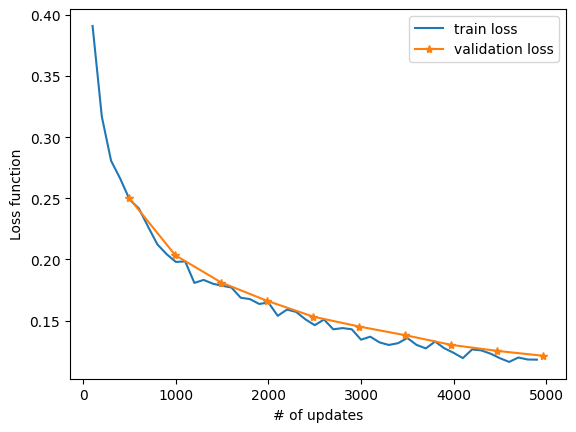

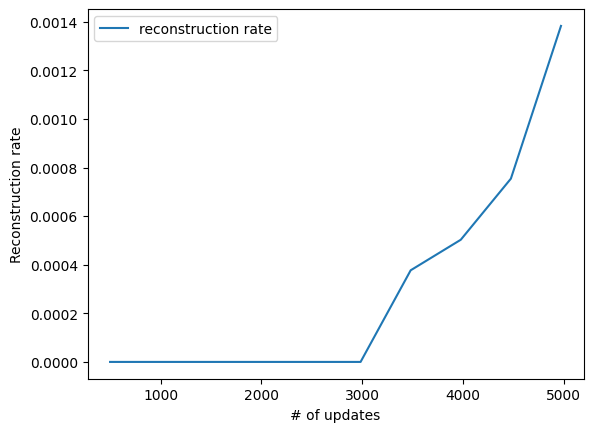

success rate: 0.575
['CC1C(C)Oc2ccccc2CN1CCN(Cc2ccc(Cl)cc2)CC1', 'O=C(Nc1ccc2ccccc2c1)c1ccccc1C(=O)Nc1ccccc1', 'Cc1nn2c(=O)ccccc2n1C(=O)Nc1ccc(Cl)cc1', 'Cc1ccc(OC(=O)NC(=O)Nc2ccc(Cl)cc2)c(C)c1', 'CCC(C(=O)OCc1cc(Cl)ccc1Cl)N1CCC(C2CCCC2)C1', 'CCOC(=O)C(=O)c1c(C)c2ccccc2c1C', 'OC(=c1ccc(-c2nc3ccc(N4CCN(Cc5ccccc5)cc4)ccc3n2)CC(O)C(O)C(O)C(C)C)c1', 'CCC(C)(N)Cn1ccc2ccccc2c1=O', 'OCOc1cc(-c2ccc3c(c2)OCOc2ccc(-c3cc(OC(=O)Nc4ccc(C(=O)NC(=O)c4ccc(Cl)cc4)cc3)ccc2)C(=O)NC(C)C)cc1', 'COC(c1cccc(Oc2ccccc2)c1)N1CCN(c2ccccc2)CC1', 'CN(C)Sc1nc(-c2ccc(N)cc2)nc(-c2ccc(Cl)cc2)n1', 'COC(=Nc1ccn2c(NC(=O)c3cc(C(=O)NCC(=O)Nc4ccccc4)ccc3)ccc2n1)c1ccccc1', 'CC(=O)NCc1cnc(-c2cc(-c3ccc(Cl)cc3)nc2C)c(C)c1C', 'COC(=Oc1ccc2ncncc2c1)NC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCN(C)C(=O)OC(C)(C)C)C(=O)CCCCCCCCCCC', 'O=C(Cc1ccccc1)NC(=O)CCNC(=O)C(Cc1ccccc1)C(=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCN(C)C', 'O=C(Nc1cccc(C(F)(F)F)c1)NC(=O)CCCNC(=O)C(C)C', 'CC(=C(N)c1cccnc1)NC(=O)CCCCN1CCN(c2ccccc2)CC1', 'NS(=O)(=O)c1ccc(NC(=O)N

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
from smiles_vocab import SmilesVocabulary

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

def valid_ratio(smiles_list):
    n_success = 0
    for each_smiles in smiles_list:
        try:
            Chem.MolToSmiles(Chem.MolFromSmiles(each_smiles))
            n_success += 1
        except:
            pass
    return n_success / len(smiles_list)


smiles_vocab = SmilesVocabulary()
train_tensor = smiles_vocab.batch_update_from_file("data/train.smi", ratio=0.1)
val_tensor = smiles_vocab.batch_update_from_file("data/valid.smi", ratio=0.1)
max_len = val_tensor.shape[1]

vae = SmilesVAE(
    vocab=smiles_vocab, latent_dim=64, emb_dim=256,
    encoder_params={"hidden_size": 512, "num_layers": 1, "bidirectional": False, "dropout": 0},
    decoder_params={"hidden_size": 512, "num_layers": 1, "dropout": 0},
    encoder2out_params={"out_dim_list": [256]},
    max_len=max_len
)
train_loss_list, val_loss_list, val_reconstruct_rate_list = trainer(
    model=vae,
    train_tensor=train_tensor,
    val_tensor=val_tensor,
    smiles_vocab=smiles_vocab,
    lr=1e-4,
    n_epoch=10,
    batch_size=256,
    beta_schedule=[0.1],
    print_freq=100,
    device="cuda"
)

plt.plot(*list(zip(*train_loss_list)), label="train loss")
plt.plot(*list(zip(*val_loss_list)), label="validation loss", marker="*")
plt.legend()
plt.xlabel("# of updates")
plt.ylabel("Loss function")
plt.show()

plt.plot(*list(zip(*val_reconstruct_rate_list)), label="reconstruction rate")
plt.legend()
plt.xlabel("# of updates")
plt.ylabel("Reconstruction rate")
plt.show()

smiles_list = vae.generate(sample_size=1000, deterministic=True)
print(f"success rate: {valid_ratio(smiles_list)}")
torch.save(vae.state_dict(), "data/vae.pt")

with open("data/vae_smiles.pkl", "wb") as f:
    pickle.dump(smiles_list, f)

print(smiles_list)